In [1]:
import pandas as pd
import numpy as np
import utilities.misc as um
import utilities.constants as uc
import pdb
from blp.bdx import bdh,bdp,bds
from fql.fql import Factset_Query
from fql.util import bbg_to_fs, fs_to_bbg,fql_date
from blp.util import get_bbg_usual_col, group_marcap,get_ashare_exchange,load_compo
import feather
import os

#plotly related
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import utilities.display as ud

from datetime import datetime

import utilities.mathematics as umath

from joblib import load, dump

import matplotlib.pyplot as plt



from interpret import show
from interpret.glassbox import ExplainableBoostingRegressor

In [80]:
path=uc.root_path_data+'connect\\ccass\\'

data=feather.read_dataframe(path+'to_fit_all.feather') # just dropna for quick dirty results
data_loss=len(data.dropna())/len(data)
print ('data loss after dropna %s' % (1-data_loss))
data=data.dropna()

windows=[20]

to_keep=(
        ['stake_marcap']
        +['ret_%s' % (x) for x in windows]
        +['consistency_%s' % (x) for x in windows]
        +['flow_%s' % (x) for x in windows]
        +['impact_turnover_%s' % (x) for x in windows]
        
        )

data=data[['date', 'ticker',]+to_keep].copy()

for keep_i in to_keep:
    data[keep_i+'_rank']=data.groupby('date')[keep_i].rank(pct=True,method='min')
    data[keep_i+'_z']=data.groupby('date')[keep_i].apply(lambda x: (x-x.mean())/x.std())
    data[keep_i+'_z']=data[keep_i+'_z'].map(lambda x: x/abs(x)*2.5 if abs(x)>=2.5 else x)
    
data['flow_rank_x_consistency_rank_%s' % (windows[0])]=data['flow_%s_rank' % (windows[0])]*data['flow_%s_rank' % (windows[0])]

data loss after dropna 0.05083067308816025


In [81]:
def get_ebm_res(ebm):

    exp_global=ebm.explain_global()
    exp_data=exp_global.data
    features=exp_global.feature_names
    feature_types=ebm.feature_types


    importance=pd.Series(index=exp_data()['names'],data=exp_data()['scores']).rename('importance').to_frame()

    collector_shape=[]
    collector_density=[]
    for i,feature_i in enumerate(features):
        # note that names will always have one more data point than score as it's the bins
        shape_i=pd.DataFrame(index=exp_data(i)['names'][1:],columns=['shape_lower','shape','shape_upper'])
        shape_i['shape_lower']=exp_data(i)['lower_bounds']
        shape_i['shape']=exp_data(i)['scores']
        shape_i['shape_upper']=exp_data(i)['upper_bounds']
        shape_i.index.name='range_actual'
        shape_i=shape_i.reset_index()
        shape_i.index.name='range'

        density_i=pd.Series(index=exp_data(i)['density']['names'][1:],data=exp_data(i)['density']['scores'])
        density_i=density_i/density_i.sum()
        density_i=density_i.rename('freq_pct').to_frame()
        density_i['freq_pct_cumu']=density_i.cumsum()
        density_i.index.name='range_actual'

        shape_i['feature']=feature_i
        density_i['feature']=feature_i
        shape_i['binning']=feature_types[i]

        collector_shape.append(shape_i)
        collector_density.append(density_i)

    shapes=pd.concat(collector_shape).reset_index()
    densities=pd.concat(collector_density).reset_index()
    
    return importance, shapes, densities
    

In [167]:
ys=['ret_20_z']
binnings=['uniform']#,'quantile']

# x='flow_rank_x_consistency_rank_20'
# x='flow_20_rank'
# x='consistency_10'
# x='flow_20_z'
x='impact_turnover_20_z'

collector=[]
collector_density=[]
for binning in binnings:
    for y in ys:

        xs=[x]
        # xs=['flow_rank_x_consistency_rank_20','flow_20_rank','stake_marcap']
        feature_types=[binning]
        ebm=ExplainableBoostingRegressor(
            feature_types=feature_types,
            interactions=0,
            n_jobs=-1,
            max_bins=256
            )
        ebm.fit(data[xs],data[y])
        
        r2=ebm.score(data[xs],data[y])
        print (r2)
        importance, shapes, densities=get_ebm_res(ebm)

        
        shapes['binning']=binning
        shapes['y']=y
        collector.append(shapes)
        
        densities['binning']=binning
        densities['y']=y
        collector_density.append(densities)
        
shapes_comp=pd.concat(collector)
densities_comp=pd.concat(collector_density)

0.0011311959549266115


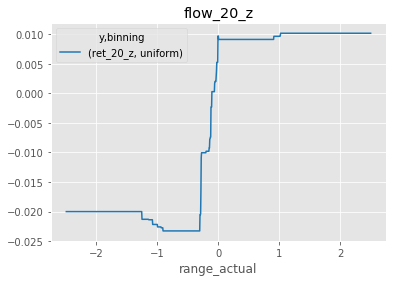

In [157]:
(shapes_comp.set_index(['range_actual','binning','y'])['shape'].unstack().unstack().fillna(method='ffill')
    .plot(color=[uc.alt_colors_quick_pd_plot[i] for i in [0,1,2,3]],title=x)
)

In [146]:
shapes_comp.set_index(['range_actual','binning','y'])['shape'].unstack().unstack()['ret_20_rank']['quantile'].dropna()

range_actual
0.000032   -0.002606
0.000098   -0.002429
0.000201   -0.002429
0.000324   -0.002429
0.000482   -0.002429
              ...   
0.971865    0.008567
0.980264    0.008567
0.988636    0.008567
0.996820    0.008716
1.000000    0.008716
Name: quantile, Length: 254, dtype: float64

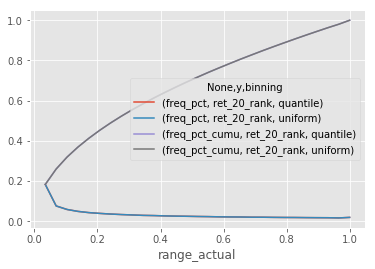

In [147]:
densities_comp.set_index(['range_actual','binning','y'])[['freq_pct','freq_pct_cumu']].unstack().unstack().plot()

# Binings strategy, max_bin, input distribution
- All you need to know: https://blog.oakbits.com/ebm-algorithm.html
- Binning: discretize the continuous feature input into n bins (default 256), and for each bin one single score is assigned (actual fitting determined by boosting tree)
- Relationship curve: should use actual range instead of relative range
- Worth examine the distribution of the input features. If uniform binning on skewed distribution, the model will be fitted on fewer data for the less frequent region. This may create some instability. In such cases we can use quantile binning. Of course we can also still use uniform binning if the absolute amount of data is sufficient
- For certain tasks, interaction effect can make significant improvement
- For transformation on y, we may use z-score, for xs transformation, better use uniform. The prediction score unit will be either in z-score or rank
- Pay attention to the prediction unit. For many real life scenarios it may not be that significant

# Binning and fitting
- For a given feature, after binning, the original x values are transformed to the bin value (same bin will have the same bin value), but the y value will remain unchanged
- So if originally within a bin there are 1000 x and 1000 corresponding y (and all different), then after the binning we will have 1 x value (the bin value) corresponding to 1000 different y value
- The gradient boosting tree works on all the bins (the entire dataset after binning/discretization)
- The higher the binning number, the higher risk of overfitting

# Binning strategy
- If the feature distribution is uniform, then it does not make much difference which binning strategy you choose, as long as the number of bins is the same. Both uniform and quantile binning will produce bins with similar widths and counts. However, if the feature distribution is not uniform, then the choice of binning strategy can have a significant impact on the resulting bins and the model performance. Uniform binning can result in bins with very uneven counts, which can lead to poor accuracy and interpretability. Quantile binning can result in bins with very uneven widths, which can lead to loss of information and sensitivity. Therefore, it is important to consider the characteristics of the feature distribution and the objectives of the model when choosing a binning strategy. 
- we can try different binning strategy simply use uniformed input

# Marginal plot of frequency to show distribution

In [1]:
# y='ret_20_rank'
# xs=['flow_20']

# ebm=ExplainableBoostingRegressor(
#     feature_types=['quantile'],
#     interactions=0,
#     n_jobs=-1,
#     )

# ebm.fit(data[xs],data[y])
# print ('done')

# show(ebm.explain_global())

In [2]:
# y='ret_20_rank'
# xs=['flow_20_z']

# ebm=ExplainableBoostingRegressor(
#     feature_types=['uniform'],
#     interactions=0,
#     n_jobs=-1,
#     )

# ebm.fit(data[xs],data[y])
# print ('done')

# show(ebm.explain_global())